<a href="https://colab.research.google.com/github/YeonJaeHong/ESAA_homeworks/blob/main/05.%20%ED%9A%8C%EA%B7%80-09_%ED%9A%8C%EA%B7%80_%EC%8B%A4%EC%8A%B5_%EC%9E%90%EC%A0%84%EA%B1%B0_%EB%8C%80%EC%97%AC_%EC%88%98%EC%9A%94_%EC%98%88%EC%B8%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 (343-)
09.회귀 실습- 자전거 대여 수요 예측





데이터 클렌징 및 가공

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
bike_df= pd.read_csv('/content/bike_train.csv')
print(bike_df.shape)
bike_df.head()

FileNotFoundError: ignored

In [ ]:
bike_df.info()

datetime 칼럼만 object 형이고 형식이 년월일~ 이런식으로 되어있으므로 이에 대한 가공이 필요하다
 > 먼저 문자열을 dattime 타입으로 변형한다 이는 apply method를 사용한다

In [ ]:
#문자열을 datetime 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년,월,일,시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x: x.year)
bike_df['month']= bike_df.datetime.apply(lambda x: x.month)
bike_df['day']=bike_df.datetime.apply(lambda x: x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

새롭게 year,month,day,hour 칼럼이 추가 되었으므로 datetime 칼럼은 삭제한다. casual+registered = count 이므로 casual과 registered 가 따로 필요하지는 않기에 삭제

In [ ]:
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1,inplace=True)

회귀모델을 데이터 세트에 적용해 예측 성능을 측정하겠음
> RMSLE와 MSE,RMSE까지 한번에 평가하는 함수도 생성

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#log 값 변환시 NaN 등의 이슈로 log() 가 아닌 log1p()를 이용해서 RMSLE 계산
def rmsle(y,pred):
  log_y=np.log1p(y)
  log_pred=np.log1p(pred)
  squared_error=(log_y-log_pred)**2
  rmsle=np.sqrt(np.mean(squared_error))
  return rmsle

#사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

#MSE,RMSE,RMSLE를 모두 계산
def evaluate_regr(y,pred):
  rmsle_val=rmsle(y,pred)
  rmse_val= rmse(y,pred)
  #MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val=mean_absolute_error(y,pred)
  print('RMSLE:{0:.3f},RMSE:{1:3F},MAE:{2:3F}'.format(rmsle_val,rmse_val,mae_val))


위의 rmsle() 함수를 만들때 한가지 주의해야 할 점이 있다.
rmsle를 구할때 넘파이의 log() 함수를 이용하거나 사이킷런의 mean_squared_log_error()를 이용할 수 도 있지만 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉬움. 이럴ㄸㅐㄴ log()보다는 log1p()를 사용 (1+log() 값이라는 뜻)

로그 변환, 피처 인코딩과 모델 학습/예측/평가
>> 회귀 모델을 적용전 데이터 세트의 결괏값이 정규 분포인지, 카테고리형 회귀몰의 경우는 원-핫 인코딩으로 피처를 인코딩 해야함

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

In [ ]:
#오류 값이 좀 커서 실제 값과 예측값의 차이를 비교해보고자함

def get_top_error_data(y_test,pred,n_tops=5):
  #dataframe의 칼럼으로 실제 대여 횟수 (count)와 예측값을 서로 비교할 수 있도록 생성
  result_df=pd.DataFrame(y_test.values,columns=['real_count'])
  result_df['predicted_count']=np.round(pred)
  result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
  #예측값과 실제 값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)


회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 정규분포가 아닌 왜곡된 형태를 이루고 있는지 확인하는 것이다.

In [ ]:
y_target.hist()

 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 log를 적용해 변환하는 것이다. 이렇게 변환된 Target 값을 기반으로 학습하고 예측한 값을 다시 exp1m() 함수로 원래 값으로 복원하면 된다. log1p()를 적용한 후 Target 값의 분포를 확인해본다

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

완벽한 정규분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상되었기에 Target 값으로 다시 학습.

In [ ]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmp1으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

In [ ]:
#RMSLE는 줄었지만, RMSE는 더 늘어났다
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

Year feature의 회귀 계수가 굉장히 큰 것을 볼 수 있다. year는 2011년, 2012년으로 2개의 값을 가지고 있으며, 자전거 대여 횟수에 크게 영향을 준다고 생각하기 어렵다. year의 회귀 계수가 이렇게 큰 값을 가지는 이유는 2011, 2012와 같이 매우 큰 값을 가지고 있기 때문이다. 이러한 숫자형으로 되어 있는 카테고리형 feature를 사용하는 경우 회귀 계수를 연산할 때 큰 영향을 받을 수 있어 one-hot 인코딩을 적용하여 변환해줘야한다. 따라서 year 뿐만 아니라 month, day, hour, holiday, workingday, season, weather column도 전부 one-hot 인코딩을 해준 후 다시 학습해보겠다. 그리고 LinearRegression, Ridge, Lasso 모두 학습한 후 예측해보겠다.

In [ ]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

>> 선형 회귀 모델 시 월 관련 feature와 workingday 관련 feature, hour 관련 feature의 회귀 계수가 높은 것을 알 수 있고 이처럼 선형 회귀 수행 시에는 feature를 어떻게 인코딩하는 지가 성능 향상에 큰 영향을 미칠 수 있음
>> 회귀 트리 모델들을 사용하여 회귀 예측 수행

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

10. 회귀 실습- 캐글 주택 가격: 고급 회귀 기법
> 성능 평가는 자전거 대여 예측 예제와 동일한 RMSLE(Root Mean Square Log Error)를 기반
> 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이를 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용한다.

데이터 사전 처리


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy() #데이터 가공을 많이 수행해야 하기에 원본 csv를 복사해서 사용하겠음
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


dataset의 feature 타입은 숫자형과 문자형
> Target을 제외하고 80개의 feature 중에서 43개가 문자형이며 나머지가 숫자형이다.
>> 데이터 양에 비해 Null 값이 많은 feature도 있으며 Null 값이 너무 많은 feature는 드롭할 것이고, Target 값의 분포를 확인해보겠다.

<Axes: title={'center': 'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

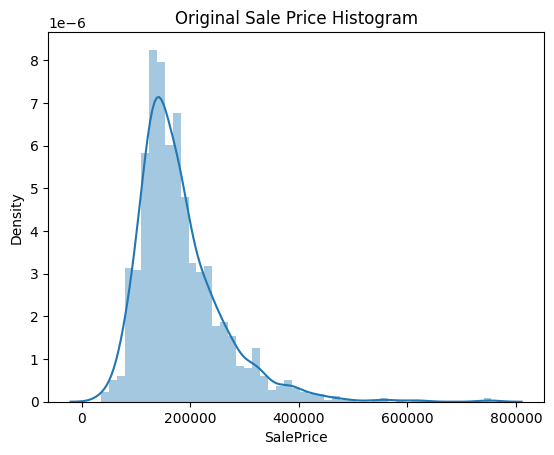

In [ ]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

<Axes: title={'center': 'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

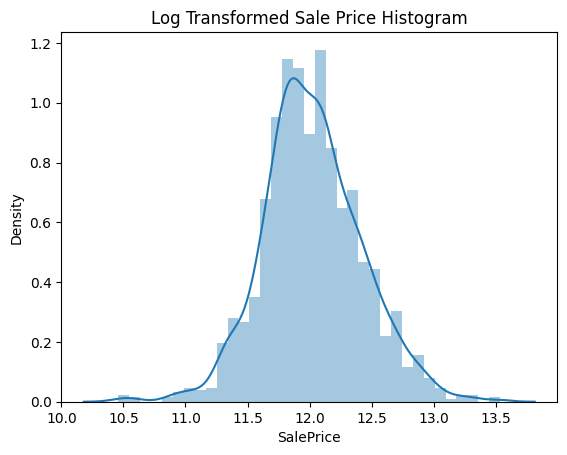

In [ ]:
#중심이 왼쪽으로 치우친 형태로 정규분포에서 벗어나 있다. 따라서 Log Transformation 을 적용하여 다시 분포도를 확인

plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

saleprice를 로그 변환 후 정규 분포 형태로 분포하는 것을 확인할 수 있었음
> 이제 로그 변환해서 DataFrame에 반영할텐데 null 값이 많은 feature: PoolQC, MiscFeature, Alley,Fence,FireplaceQu는 삭제, Id feature도 단순한 식별자이므로 삭제하고, LotFrontage는 Null 값이 259개로 많으나 평균값으로 대체하고 나머지 Null 값이 많지 않은 숫자형은 평균값으로 대체

In [ ]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(),inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자형 feature를 제외하고는 Null 값이 없다.
문자형 feature는 모두 one-hot 인코딩으로 변환할텐데 이때 사용하는 pandas의 get_dummies()은 자동으로 one-hot 인코딩으로 변환해주는데 Null 값은 'None' column으로 대체해주기 때문에 별도로 Null 값을 대체하는 로직은 필요없다.

In [ ]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


원핫인코딩 이후 피처가 75개에서 272개로 증가 그리고 null 값은 존재 하지 않음


선형 회구 ㅣ모델 학습/예측/평가
> 예측 평가 지표로 RMSLE(실제 값과 예측값의 오류를 로그 변환한뒤 rmse 적용)를 이용함. 하지만 이미 target 값이 로그 변환되었기에 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정된다. 이제 선형 회귀 모델을 학습하고 예측, 평가해보겠다.

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154297, 0.12750846334053004, 0.17628250556471403]

라쏘 회귀의 경우, hyper parameter 튜닝이 되지 않아성능이 비교적 떨어지는 결과가 나왔다. 우선 hyper parameter 튜닝을 하기 전에 feature 별로 회귀 계수를 시각화하여 모델별로 어떠한 feature의 회귀 계수로 구성되어 있는지 상위 10개, 하위 10개를 확인해보겠다.

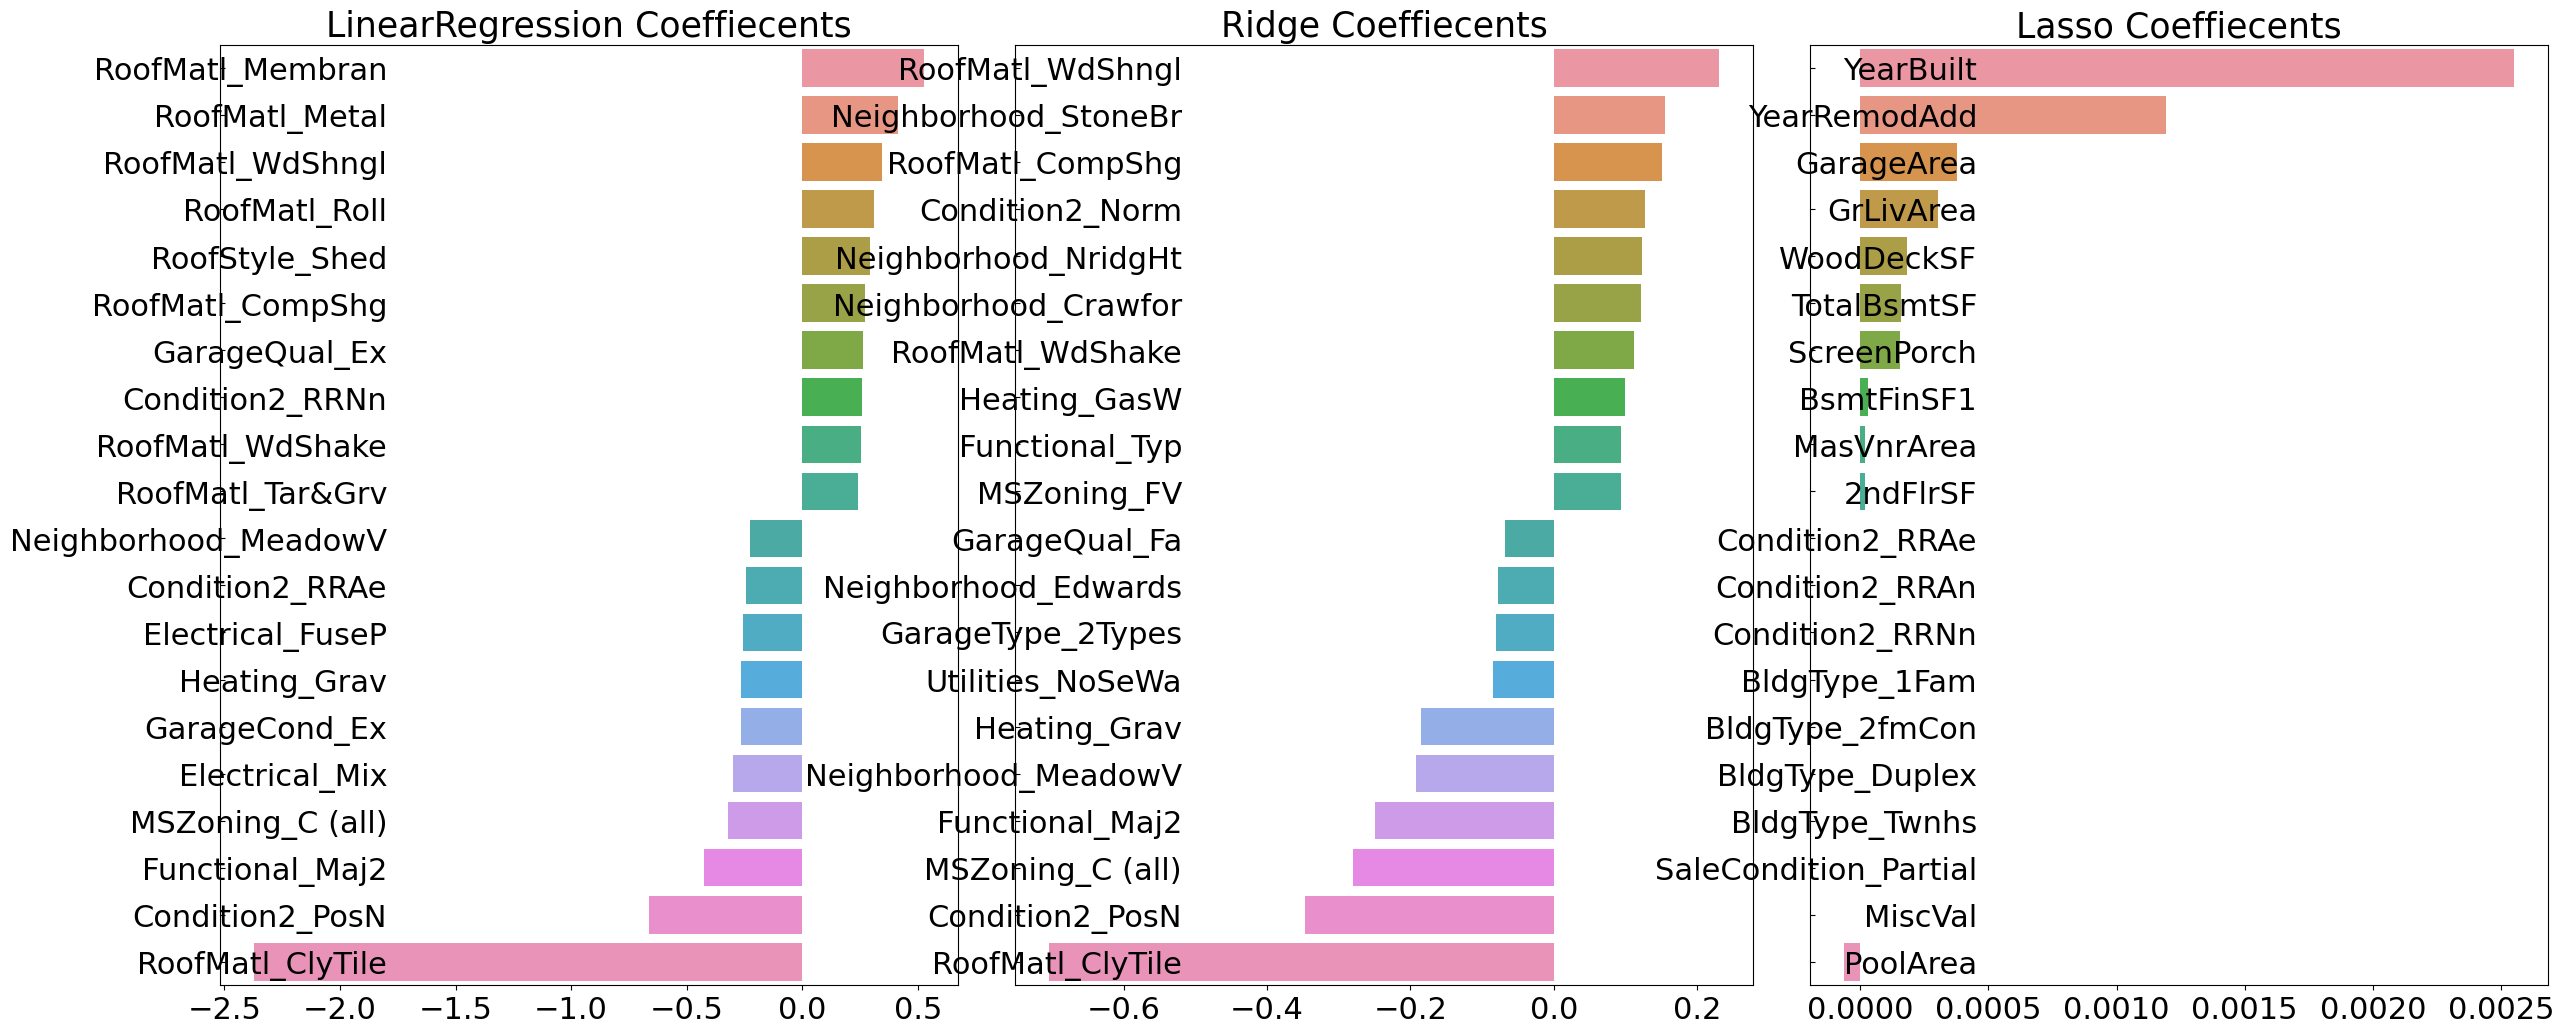

In [ ]:
def get_top_bottom_coef(model,n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 회귀계수 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

모델별 회귀 계수를 보면 OLS(Ordinary Least Squares) 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포되어 있지만, Lasso는 전체적으로 회귀 계수 값이 작으며, 그 중 YearBuilt이 가장 크고 다른 feature는 너무 작은 값을 가진다.혹시 학습 데이터의 분할이 잘못되어 있을 수 있으니 5개의 CV로 평균 RMSE를 cross_val_score()로 측정해보겠다.

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


여전히 라쏘 모델이 성능이 떨어진다. 이제 릿지와 라쏘의 alpha hyper parameter를 최적화하여 확인을 해야 한다.

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}
